In [1]:
import qsample as qs
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm
import random

# Helpers

In [2]:
def dem2matrices(dem, n_detectors):
    
    txt = dem.split('\n')[1:-1]
    dims = len(txt)
    errors = np.zeros(dims)
    err_locs = np.zeros((dims, n_detectors))

    for i in range(dims):
        errors[i] = re.findall('\d?\.?\d+e?\-?\d+', txt[i])[0]
        for j in re.findall('D\d', txt[i]):
            err_locs[i, int(j[1])]=1

    return errors, err_locs

def separate_errors(eloc, dep):

    extracted = [0]*dep
    extracted_indices = [0]*dep
    index = 0
    for ii in range(dep):
        extracted_indices[ii]=index
        index_new = sum(eloc[index:,ii]==1)+index
        extracted[ii] = eloc[index:index_new]
        index=index_new
    return extracted, extracted_indices


def sample_errors(n_samples, dep, sequence, eloc, extracted, extracted_indices):

    samples = []
    for _ in range(n_samples):
        path = np.copy(sequence)
        result = np.zeros(len(eloc))
        for jj in range(dep):
            if result is not None:
                if path[jj]==1 and len(extracted[jj])==0: #impossible path: no error can now activate the desired detectors
                    result = None
                else:
                    if len(extracted[jj]) > 3: #ignore more than 3 errors in a single subcircuit (very little chance of occuring for small p_phys)
                        w_max = 3
                    else:
                        w_max = len(extracted[jj])
                    w = random.choice(np.arange(path[jj], w_max+1,2))
                    if w>0:
                        locs = np.array(random.sample(sorted(np.arange(len(extracted[jj]))), w))+extracted_indices[jj]
                        result[locs]=1
                        path=((path+np.sum(eloc[locs], axis=0))%2).astype(int)
        if result is not None:
            samples.append(result)

    return np.unique(samples, axis=0)

In [3]:
class node:
    
    def __init__(self, circuit):
        self.circuit = circuit
        self.zero = None
        self.one = None
        
    def fail_path(self):
        fails= []
        path = []
        if self.one==1:
            path = [1]
            fails.append(path)
        else:
            for p in self.one.fail_path():
                p.append(1)
                fails.append(p)
        if self.zero!=0:
            for p in self.zero.fail_path():
                p.append(0)
                fails.append(p)
        return fails
    
    def fail_paths(self):
        p = []
        circs = []
        for j in self.fail_path():
            p.append(j[::-1])
            
        for j in p:
            node = self
            circ = node.circuit
            for i in j[:-1]:
                if i == 1:
                    circ+=node.one.circuit
                    node = node.one
                if i == 0:
                    circ+=node.zero.circuit
                    node = node.zero
            circs.append(circ)
            
        return p, circs

In [19]:
class node:
    
    def __init__(self, circuit):
        self.circuit = circuit
        self.outcomes = None
        
    def fail_paths(self):
        fails= []
        circs= []
        path = []
        head = ""
        for (k, v) in self.outcomes.items():
            if v == "FAIL":
                path = [k]
                head = self.circuit
                fails.append(path)
                circs.append(head)
            elif v != "OK":
                for (p, h) in zip(v.fail_paths()[0], v.fail_paths()[1]):
                    if isinstance(k, str):
                        k_list = list(k)
                        p=[int(i) for i in k_list]+p
                    else:
                        p=[k]+p
                    head = self.circuit+h
                    circs.append(head)
                    fails.append(p)
        return fails, circs

# QSample

In [5]:
eft = qs.Circuit([  {"init": {0,1,2,4,3,5,6,7}},
                    {"H": {0,1,3}},
                    {"CNOT": {(0,4)}},
                    {"CNOT": {(1,2)}},
                    {"CNOT": {(3,5)}},
                    {"CNOT": {(0,6)}},
                    {"CNOT": {(3,4)}},
                    {"CNOT": {(1,5)}},
                    {"CNOT": {(0,2)}},
                    {"CNOT": {(5,6)}},
                    {"CNOT": {(4,7)}},
                    {"CNOT": {(2,7)}},
                    {"CNOT": {(5,7)}},
                    {"measure": {7}} ])

sz_123 = qs.Circuit([   {"init": {8}},
                        {"CNOT": {(0,8)}},
                        {"CNOT": {(1,8)}},
                        {"CNOT": {(3,8)}},
                        {"CNOT": {(6,8)}},
                        {"measure": {8}}])

meas7 = qs.Circuit([ {"measure": {0,1,2,3,4,5,6}} ], noisy=False)

k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count


def logErr(out):

    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

steane0 = qs.Protocol(check_functions=functions, fault_tolerant=True)

steane0.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas7])
steane0.add_node('X_COR', circuit=qs.Circuit([{'X': {6}}], noisy=True))
steane0.add_edge('START', 'ENC', check='True')
steane0.add_edge('ENC', 'meas', check='ENC[-1]==0')
steane0.add_edge('ENC', 'Z2', check='ENC[-1]==1')
steane0.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')
steane0.add_edge('Z2', 'meas', check='not lut(Z2[-1])')
steane0.add_edge('X_COR', 'meas', check='True')
steane0.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

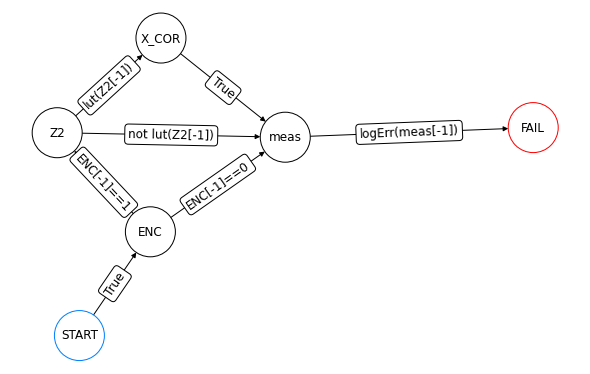

In [6]:
steane0.draw(figsize=(8,5))

In [7]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': q}

In [8]:
begin = time.time()
ss_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StabilizerSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(1000)
end = time.time()
qsample_time = end-begin

p=('1.00e-01',):   0%|          | 0/1000 [00:00<?, ?it/s]

## STIM

In [32]:
ENC = """H 0 1 3\nDEPOLARIZE1({q}) 0 1 3\n
                    CNOT 0 4\nDEPOLARIZE2({q}) 0 4\n
                    CNOT 1 2\nDEPOLARIZE2({q}) 1 2\n
                    CNOT 3 5\nDEPOLARIZE2({q}) 3 5\n
                    CNOT 0 6\nDEPOLARIZE2({q}) 0 6\n
                    CNOT 3 4\nDEPOLARIZE2({q}) 3 4\n
                    CNOT 1 5\nDEPOLARIZE2({q}) 1 5\n
                    CNOT 0 2\nDEPOLARIZE2({q}) 0 2\n
                    CNOT 5 6\nDEPOLARIZE2({q}) 5 6\n
                    CNOT 4 7\nDEPOLARIZE2({q}) 4 7\n
                    CNOT 2 7\nDEPOLARIZE2({q}) 2 7\n
                    CNOT 5 7\nDEPOLARIZE2({q}) 5 7\n
                    M 7\n
                    DETECTOR rec[-1]
                      """

sz_123 = """CNOT 0 8\nDEPOLARIZE2({q}) 0 8\n
            CNOT 1 8\nDEPOLARIZE2({q}) 1 8\n
            CNOT 3 8\nDEPOLARIZE2({q}) 3 8\n
            CNOT 6 8\nDEPOLARIZE2({q}) 6 8\n
                        M 8\n
                        DETECTOR rec[-1]\n
                        TICK\n
                        """

x_cor = """X 6\nDEPOLARIZE1({q}) 6\n"""

meas7 = "\nTICK\nM 0 1 2 3 4 5 6\n"


KZ1 = """\nCNOT 3 9\nCNOT 4 9\nCNOT 5 9\nCNOT 6 9\nM 9\nDETECTOR rec[-1]\n"""
KZ2 = """\nCNOT 0 10\nCNOT 2 10\nCNOT 4 10\nCNOT 6 10\nM 10\nDETECTOR rec[-1]\n"""
KZ3 = """\nCNOT 1 11\nCNOT 2 11\nCNOT 5 11\nCNOT 6 11\nM 11\nDETECTOR rec[-1]\n"""


LOG_Z = """\nCNOT 0 12\nCNOT 1 12\nCNOT 2 12\nCNOT 3 12\nCNOT 4 12\nCNOT 5 12\nCNOT 6 12\nM 12\nDETECTOR rec[-1]"""

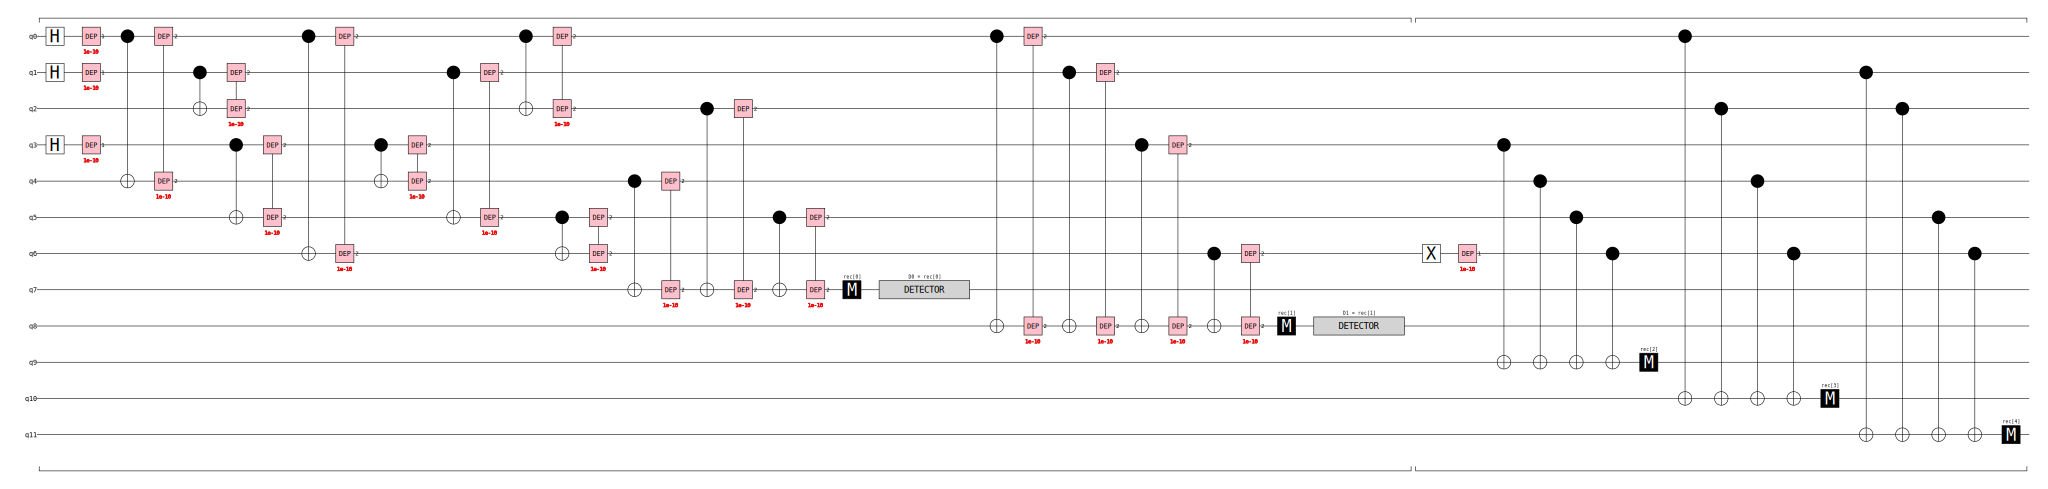

In [16]:
circuit = stim.Circuit((ENC+sz_123+x_cor+KZ1+KZ2+KZ3).format(q=1e-10))
circuit.diagram('timeline-svg')

In [37]:
x0 = node( """\nX 0"""+meas7+LOG_Z)
x0.outcomes = {0:"OK", 1:"FAIL"}
x1 = node( """\nX 1"""+meas7+LOG_Z)
x1.outcomes = {0:"OK", 1:"FAIL"}
x2 = node( """\nX 2"""+meas7+LOG_Z)
x2.outcomes = {0:"OK", 1:"FAIL"}
x3 = node( """\nX 3"""+meas7+LOG_Z)
x3.outcomes = {0:"OK", 1:"FAIL"}
x4 = node( """\nX 4"""+meas7+LOG_Z)
x4.outcomes = {0:"OK", 1:"FAIL"}
x5 = node( """\nX 5"""+meas7+LOG_Z)
x5.outcomes = {0:"OK", 1:"FAIL"}
x6 = node( """\nX 6"""+meas7+LOG_Z)
x6.outcomes = {0:"OK", 1:"FAIL"}
ok = node(meas7+LOG_Z)
ok.outcomes = {0:"OK", 1:"FAIL"}

kz1 = node(KZ1+KZ2+KZ3)
kz1.outcomes = {'000':ok, '001':x1, '010':x0, '011':x2, '100':x3, '101':x5, '110':x4, '111':x6}

xkz1 = node(x_cor+KZ1+KZ2+KZ3)
xkz1.outcomes = kz1.outcomes

sz = node(sz_123)
sz.outcomes={0:kz1, 1:xkz1}

enc = node(ENC)
enc.outcomes = {0:kz1, 1:sz}

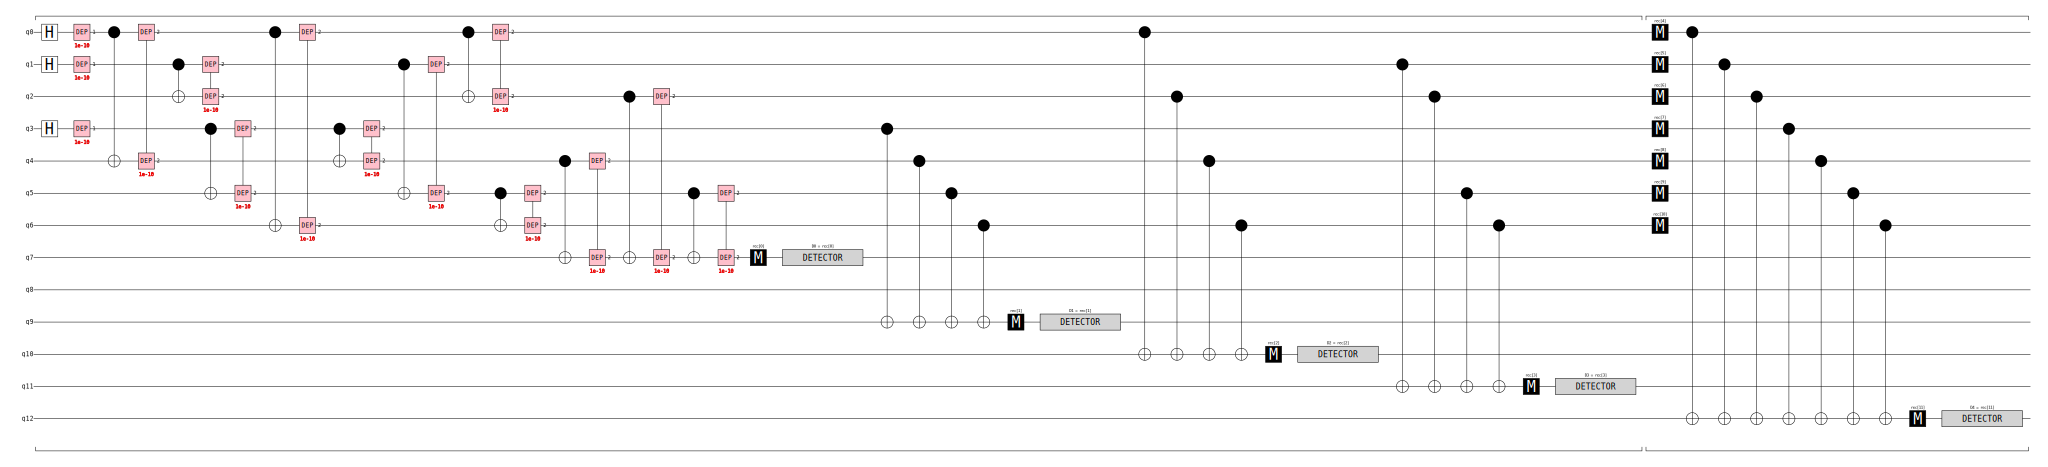

In [42]:
circuit = stim.Circuit(circuits[0].format(q=1e-10))
circuit.diagram('timeline-svg')

In [57]:
err_total = np.zeros(len(q))
begin = time.time()
paths, circuits = enc.fail_paths()
for p in range(len(paths)):
    
    circuit = stim.Circuit(circuits[p].format(q=1e-10)) #arbitrary error rate
    dem = circuit.detector_error_model()
    
    sampler = circuit.compile_sampler()
    outcome = sampler.sample(shots=1)
    outcome = np.concatenate((outcome[0,:-8], outcome[0,-1:]))
    paths[p]-=outcome
    
    errors, errloc = dem2matrices(repr(dem),len(paths[p]))
    err = len(errors)
    depth = len(paths[p])
    extracted, extracted_indices = separate_errors(errloc, depth)
    
    #n_samples = np.prod([len(i)**(2*(len(i)>1)) for i in extracted])
    #print(n_samples)
    n_samples=1000
    result = sample_errors(n_samples, depth, paths[p], errloc, extracted, extracted_indices)

    for i in range(len(q)):
        circuit = stim.Circuit(circuits[p].format(q=q[i]))
        dem = circuit.detector_error_model()
        errors, errloc = dem2matrices(repr(dem),len(paths[p]))
        if len(result)>0:
            err_total[i]+= np.sum(np.prod(errors*result+(1-errors)*(1-result), axis=1))


end = time.time()
stim_time = end-begin

# Comparison

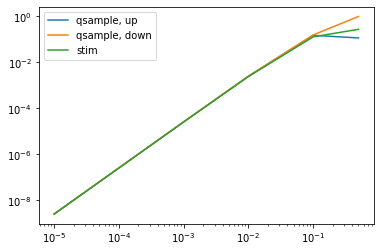

In [58]:
plt.plot(q, ss_sam.stats()[0], label = 'qsample, up')
plt.plot(q, ss_sam.stats()[2], label = 'qsample, down')
plt.plot(q, err_total, label = 'stim')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [59]:
print("QSample time: {:.3}s".format(qsample_time))
print("STIM time: {:.3}s".format(stim_time))
print(qsample_time/stim_time)

QSample time: 1.02s
STIM time: 1.69s
0.6055896971722513
